## NEURAL NETWORKS AND DEEP LEARNING A.A. 2021/22

### Samuele Pio Lipani 2025168

### Homework 3 - Reinforcement Learning

#### Cartpole Game 

In [1]:
import random
import numpy as np
import glob
import io
import base64
import os
from tqdm.notebook import tqdm
from IPython.display import HTML
from IPython import display as ipythondisplay
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
import plotly.express as px
from torch import nn
import torch
from collections import deque, namedtuple 
import gym

# Experience replay (Replay Memory)

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

## Network definition

In [3]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [4]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [5]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [6]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.18221912 -0.16208027]


### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [7]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [8]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.18221912 -0.16208027]


### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax\_ temperature}  = \text{initial\_ temperature} \cdot \text{exp\_ decay}^i \qquad \text{for $i$ = 1, 2, \dots, num\_ iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

In [9]:
def softmax_expl(num_iterations=1000, initial_value=5):
    # We compute the exponential decay in such a way the shape of the exploration 
    # profile does not depend on the number of iterations
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

def gaussian(x, mu = 0, sig = 1):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

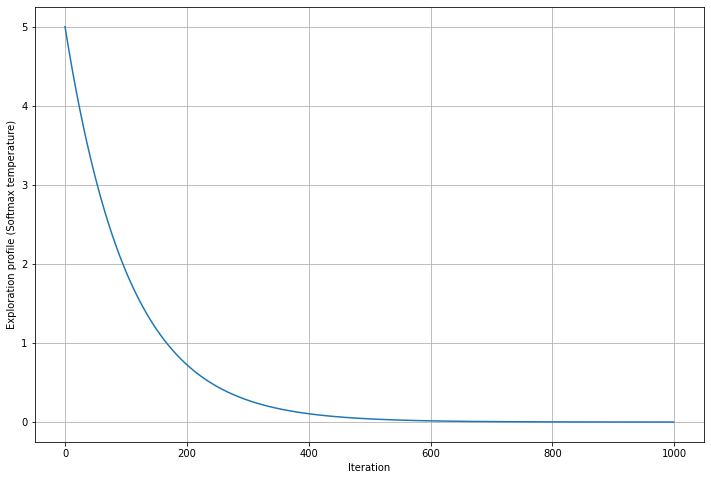

In [10]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)');

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over.

https://gym.openai.com/envs/CartPole-v1/

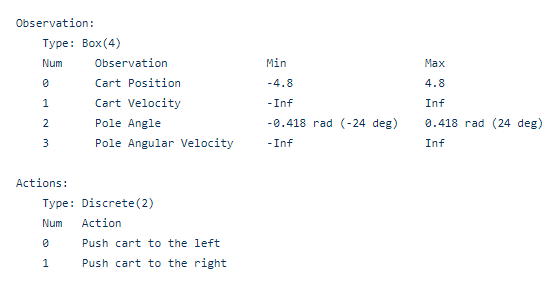

The observation space of the environment O and its action space A are described as follows:

O = [Cart position, Cart velocity, Pole angle, Pole angular velocity] A = [ Move left, Move right ]

The aim of the agent is to keep the pole balanced for as long as possible, but the trial is considered solved at 500 time steps. For each time step that the pole is balanced the agent gets +1 to the reward. 

In Q-learning the agent learns to associate a value to each state-action pair, which takes into account both the immediate reward for that action and the future rewards. In particular, an update step is defined as:

$$
Q(s_t,a_t) \rightarrow Q(s_t,a_t) + \lambda(r_t + \gamma \cdot max_a Q(s_t,a_t) - Q(s_t,a_t))
$$

where $s_t, a_t$ are the state and the action at time t, $\lambda$ is the learning rate and $\gamma$ the discount factor that takes into account how much future rewards matter. Notice that in the update which is the maximum Q value of the actions in the state at the next time step is taken into account. Given the Q-values we then need a policy, i.e. a way of selecting which action to perform. Softmax policy will be used, i.e. select which action to perform based on their Q-values. It is however important to explore the environment at the initial stages of the learning: if the best action is always selected when the full system is not known the network may be stuck in local minima. Softmax with temperature is implemented, setting an exploration profile, i.e. an evolution of the temperature T such that at the initial time we select random actions ($T > 1$) and towards the end of the simulation we select the best action ($T \rightarrow 0$). In particular, an exponential decay for the exploration profile will be used.
Gaussian addition will be randomly insert to the profile, to see their effect.
A neural network is used then to calculate the Q-values. There are, however, some problems in this approach. The training dataset is built incrementally, the samples are not identically independently distributed and the target function is non-stationary. Therefore two workarounds are introduced:
- A Replay memory. Store tuples of (state, action, reward, next state) in a memory buffer, such that in the training mini-batches can be sampled from this buffer and "replay" those states. This is really important, because there will be no longer forced need to use subsequent time step in the training, decreasing the correlation between samples.
- A Target network. There won't be used the same network for evaluating $Q(s_t,a_t)$ and $Q(s_{t+1},a_{t})$ in the update rule. A target network instead will be used for the latter, which weights are updated from the first network, called policy network, each n episodes. This helps for the non-stationarity of the target function.

For the optimization of the network stochastic gradient descent (SGD) is chosen, but without momentum. This is because, differently from other deep learning frameworks, in reinforcement learning it is possible that the optimization direction changes quickly, due to the dynamical nature of the problem.
In the reward function it is added a linear penalty proportional to the distance from the center of the screen, due to a problematic behavior of the agent that tried to "exit" from the screen.

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(1999) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


##### Example 

C:\Users\samue\AppData\Local\Programs\Python\Python38\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Impossibile cambiare la modalità del thread dopo averla impostata
  warnings.warn(str(err))


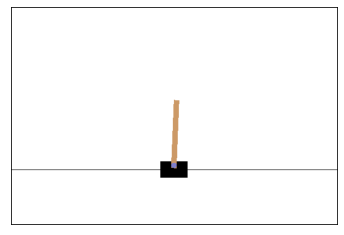

In [12]:
# in order to get a step of the simulation it's possible to directly extract it from the gym env created 

env = gym.make('CartPole-v1') 
state = env.reset()
# Images are 600x400 pixels
s_shot = env.render(mode='rgb_array')
s_shot = np.ascontiguousarray(s_shot, dtype=np.float32)/255.
env.close()
plt.imshow(s_shot)
plt.yticks([]);
plt.xticks([]);

## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [13]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1999) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 25.0
EPISODE 2 - FINAL SCORE: 21.0
EPISODE 3 - FINAL SCORE: 27.0
EPISODE 4 - FINAL SCORE: 14.0
EPISODE 5 - FINAL SCORE: 57.0
EPISODE 6 - FINAL SCORE: 33.0
EPISODE 7 - FINAL SCORE: 13.0
EPISODE 8 - FINAL SCORE: 30.0
EPISODE 9 - FINAL SCORE: 32.0
EPISODE 10 - FINAL SCORE: 22.0


# Network update

## Update function

In [14]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [15]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(1999) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            if episode_num % 100 == 0:
                env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

## Initialization

In [16]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn


In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [17]:
explorations = []

for i in range(10):
    exp = softmax_expl(initial_value=np.random.randint(3, 7))
    N = len(exp)
    if np.random.rand() < 0.7:
        j = np.random.randint(0, 9)
        g = gaussian(np.linspace(-3, 3, 100))
        exp[j* (N//10): (j+1)*(N//10)] += g
        
        if np.random.rand() < 0.7:
            j = np.random.randint(0, 9)
            exp[j* (N//10): (j+1)*(N//10)] += gaussian(np.linspace(-3, 3, 100))
    explorations.append(exp)

In [ ]:
params_tot = []
tr_score_tot = []
expl_prof_tot = []

gamma = np.linspace(0.9, 0.99, 10)
lr = np.logspace(-3, -1, 10)
batch_size = [32, 64, 128, 256]
target_up_steps = np.arange(5, 25, 5, dtype=int)

for i in range(10):
    
    ### Set exploration profile
    exploration_profile = explorations[ np.random.randint(0, 10)]
    
    ### PARAMETERS
    params = {}
    params['gamma'] = np.random.choice(gamma)   
    replay_memory_capacity = 10000   
    params['lr'] = np.random.choice(lr)   
    params['target_net_update_steps'] = np.random.choice(target_up_steps)   
    params['batch_size'] = np.random.choice(batch_size)  
    params['bad_state_penalty'] = 0   
    min_samples_for_training = 1000   

    # Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    # Training
    policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                                params, verbose=False)
    
    params_tot.append(params)
    tr_score_tot.append(training_score)
    expl_prof_tot.append(exploration_profile)

## Parameters optimization
- the exploration profile, of which the starting temperature will be changed. As cited before, gaussian increment of temperature at random position is added in the profile with probability $p = 0.3$, to understand its effect on the optimization. The exploration profile will be made of 1000 points;
- the discount rate $\gamma$;
- the target update time n;
- the learning rate $\lambda$;
- the mini-batch size.

# Results
The best set of parameters is the one that achieves the less time to reach 490 of score:

In [40]:
for i in range(10):
    temp = np.argwhere(np.array(tr_score_tot[i]) >= 490)
    if len(temp)>0:
        params_tot[i]['first_solved'] = temp[0][0]
    else:
        params_tot[i]['first_solved'] = 1000
    
def best_set(params):
    """
    the function returns both the index of the best set of parameters and the best set itself. The index is useful 
    for plotting the best correspondant tr_score
    """
    # iterating over the values of the list of dictionaries 
    dummy = [dic['first_solved'] for dic in params_tot]
    idx = np.argmin(dummy)
    return idx, params_tot[idx]

let's see however the overall behaviors of the ten models through a dataframe 

In [42]:
import pandas as pd
pd.DataFrame(params_tot)

,gamma,lr,target_net_update_steps,batch_size,bad_state_penalty,first_solved
0,0.96,0.001000,10,64,0,858
1,0.95,0.021544,10,64,0,748
2,0.93,0.100000,10,32,0,1000
3,0.90,0.012915,20,256,0,1000
4,0.98,0.100000,5,64,0,302
5,0.99,0.059948,15,256,0,513
6,0.94,0.007743,10,32,0,1000
7,0.92,0.002783,5,128,0,1000
8,0.98,0.004642,20,128,0,967
9,0.98,0.007743,5,128,0,415


The performances of the algorithm are strongly dependent on the hyperparameters. The hyperparameter search is depicted in the dataframe, where the first_solved axis is defined as the first time at which the agent performs at least 490 points. If the agent is not able to solve the environment then we assign a first_solved value of 1000. The best performing agents have mostly a high learning rate $\lambda$, a high discount rate $\gamma$ and a frequent update of the target network.

# Plotting results

To better understand the evolution of the training and the effect of the exploration profile let's plot the exploration profile and the training score, i.e. the score along all the points of the exploration. The training score oscillates a lot along the evolution. The figure shows clearly that, when the hyperparameter set is optimal, the score abruptly increases as soon as the temperature approaches zero, i.e. when the agent starts to choose the best action. This means that the learning is really fast. A bad choice can instead damage the learning so much that the agent is never able to solve the environment.

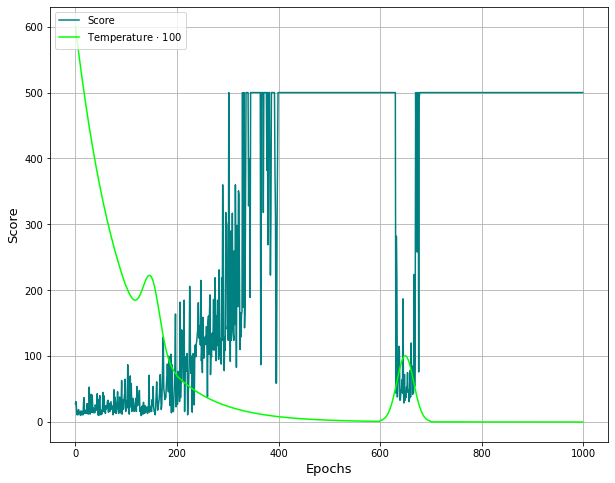

In [43]:
num_epochs = np.arange(1000)

plt.figure(figsize=(10,8))
plt.plot(num_epochs, tr_score_tot[best_set(params)[0]], "teal")
plt.plot(num_epochs, np.array(expl_prof_tot[best_set(params)[0]])*100, "lime")
plt.ylabel('Score', size = 13)
plt.xlabel('Epochs', size = 13)
plt.grid()
plt.legend(['Score','Temperature $\cdot$ 100'], loc ="upper left")
plt.show()

# Final test

In [44]:
# Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params_tot[best_set(params)[0]])

# Training
policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                            params_tot[best_set(params)[0]], verbose=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
torch.save(policy_net.state_dict(), 'perfect_cartpole')

Let's see if actually the reached score of the best model game is the maximum for a ten total number of episodes

In [46]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


# Acrobot game gym environment 
Acrobot is a game, in which a robotic arm is composed of two joints and two links and the joint between the two links is actued. In the beginning, the links are hanging downwards. The goal of the task is to move the end of the lower link up to a given height.

When the robotic arm chooses and performs an action, it may receive a reward or not. In each time step, it receives -1 as punishment until the goal is reached. Then, the agent’s task is to understand which actions can maximize the cumulative reward. There are three possible actions:

- Apply positive torque (+1)
- Apply negative torque (-1)
- Do nothing (0)

The environment imposes 500-time steps for each episode if the agent doesn’t reach its goal before. Then, the worst cumulative reward is -500.

## Instantiate environment

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)

print(env.action_space)
print(env.observation_space)
# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

Discrete(3)
Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


The action space is discrete, so the action can be one of these non-negative numbers: [0,1,2]. Differently from the action space, the observation space is Box, which represents an n-dimensional box. Then, each observation will be an array of 6 numbers with a range between -28 and 28.

## Random Agent
This is an example of running an agent which simply chooses an action randomly. The Acrobot environment will run for 10 episodes, showing the video of the game at each step.

In [3]:
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score > -500:
      # Choose a random action
      action = random.choice([0, 1, 2])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (-1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

EPISODE 1 - FINAL SCORE: -500.0
EPISODE 2 - FINAL SCORE: -500.0
EPISODE 3 - FINAL SCORE: -500.0
EPISODE 4 - FINAL SCORE: -500.0
EPISODE 5 - FINAL SCORE: -500.0
EPISODE 6 - FINAL SCORE: -500.0
EPISODE 7 - FINAL SCORE: -500.0
EPISODE 8 - FINAL SCORE: -500.0
EPISODE 9 - FINAL SCORE: -500.0
EPISODE 10 - FINAL SCORE: -500.0


## DQN
The model is a neural network that takes as input the dimension of the state space and returns the optimal q-value corresponding to each possible action. Since there are three possible actions to move the robotic arm, the number of outputs returned are 3.

Once defined the network, let's create a class called ReplayMemory. The neural networks may be unstable or diverge when the correlation is present in the sequence of observations. For this reason, there is also the need for the Experience Replay, which enables agents to remember and learn from experiences in the past. Moreover, it randomizes over the data, thereby it provides uncorrelated data.
To perform experience replay, agent’s experiences are stored $e_t$=(state, action, next state, reward) at each time step t in a dataset $D_t=\{e_1, \dots ,e_t \}.$ During learning, Q-learning updates are applied, on samples (or mini-batches) of experience $(s,a,r,s’)\sim U(D)$, drawn uniformly at random from the pool of stored samples.
In practice, a queue with a predefined capacity is needed. When the maximum capacity is reached, the oldest element in the queue will be replaced with the new one. This behaviour can be reached using the deque object from the python collections library.

In [4]:
class ReplayMemory(object):

    def __init__(self, capacity):
        # Define a queue with maxlen "capacity"
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # Randomly select "batch_size" samples and return the selection
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )

    def forward(self, x):
        x = x.to(device)
        return self.linear(x)

def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

After performing the experience replay, the next step is to select and perform an action according to the epsilon-greedy policy. This policy chooses a random action with probability epsilon, otherwise choose the best action corresponding to the highest Q-value. The main idea is that the agent explores the environment rather than exploiting it at the beginning. The more the agent learns from the environment, the more it will choose the optimal actions, based on exploitation.

The Softmax policy is used to choose the optimal action, based on a distribution obtained applying a softmax to the estimated Q-values, given the temperature parameter. There are two possible cases:
- the higher the temperature, the more the distribution will converge to a random uniform distribution.
- At zero temperature, the policy will always choose the action with the highest Q-value.

An exponentially decreasing exploration profile using a softmax policy is defined: 
$$
\text{softmax\_ temperature} = \text{initial\_ temperature} \cdot \text{exponential\_ decay}^{i}
$$

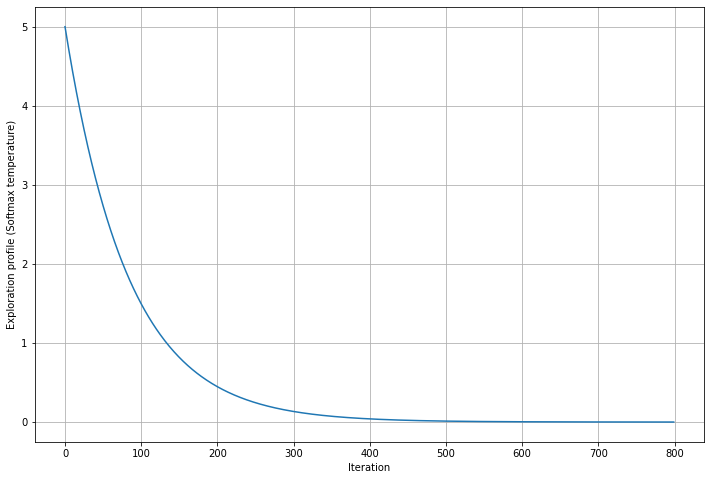

In [5]:
### Define exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration');
plt.ylabel('Exploration profile (Softmax temperature)');

In [6]:
### Create environment
env = gym.make('Acrobot-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 6
ACTION SPACE SIZE: 3


Let's initialize hyperparameters, like the SGD optimizer and the Huber loss function, the ReplayMemory object, the policy network and the target network.

In [7]:
# Set random seeds
torch.manual_seed(1999)
np.random.seed(1999)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
#lr = 1e-2   # Optimizer learning rate
#lr = 1e-4
lr = 1e-3
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 256   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [8]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [9]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

The function update_step is defined to perform a single step of optimization. First, it samples a batch from the replay memory. After, it creates tensors for each element of the batch. It also computes a mask of non-final states and concatenates the batch elements.
Later, it calculates all the Q-values of the policy network given the actual states. Differently from the policy network, the value function is computed based on the next states using the target network.
Finally, the expected Q values can be obtained, based on the Q-values of the policy network and the maximum of Q-values calculated using the target network.

The train is run over 800 episodes with that given parameters initialized before. The reason why a parameters optimization is not implemented is purely for computational effort and time this simple game spends.

In [10]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += reward

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/800 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: -500.0 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: -500.0 - Temperature: 4.940008876649582


<ipython-input-9-0088741b6db9>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)


EPISODE: 3 - FINAL SCORE: -500.0 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: -500.0 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: -500.0 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: -500.0 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: -500.0 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: -500.0 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: -500.0 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: -356.0 - Temperature: 4.485279683605809
Updating target network...
EPISODE: 11 - FINAL SCORE: -500.0 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: -500.0 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: -500.0 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: -500.0 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: -500.0 - Temperature: 4.222582601051861
EPISODE: 16 - FINAL SCORE: -500.0 - Temperature: 4.171919106316454
EPISODE: 17 - FINAL SCORE: -500.0 - Temper

## Plotting results
In the beginning, the accumulated reward remains -500. After 200 episodes, the score increases exponentially, remaining constant at around -100. Instead of taking a random action, the optimal action is chosen with the temperature parameter set equal to 0. In this way, the softmax policy will always select the action with the highest Q-value.
The cumulative reward scores remain small at the final test results.

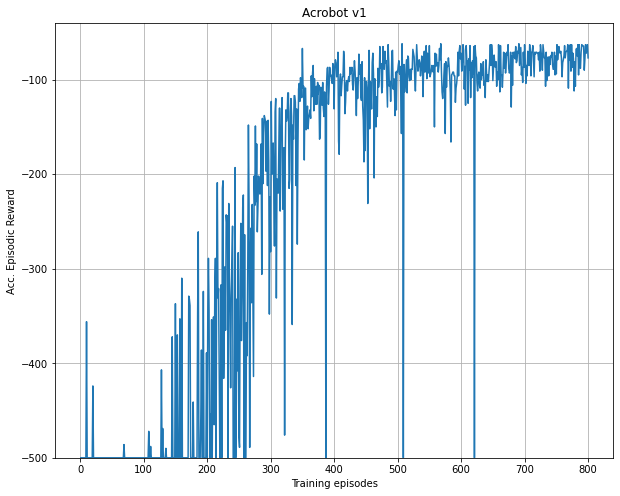

In [11]:
plt.figure(figsize=(10,8))
plt.plot(range(1,801),plotting_rewards)
plt.xlabel('Training episodes')
plt.ylabel('Acc. Episodic Reward')
plt.ylim([-500,-40])
plt.grid()
plt.title('Acrobot v1')
plt.show()

In [ ]:
# Initialize the Gym environment
env = gym.make('Acrobot-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

plotting_rewards2=[]
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # s_shot = env.render(mode='rgb_array')
      # s_shot = np.ascontiguousarray(s_shot, dtype=np.float32);
      # plt.imshow(s_shot)
      # plt.yticks([]);
      # plt.xticks([]); 
      # Check if the episode ended (the pole fell down)
    # Print the final score
    plotting_rewards2.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: -82.0
EPISODE 2 - FINAL SCORE: -107.0
EPISODE 3 - FINAL SCORE: -74.0
EPISODE 4 - FINAL SCORE: -90.0
EPISODE 5 - FINAL SCORE: -87.0
EPISODE 6 - FINAL SCORE: -92.0
EPISODE 7 - FINAL SCORE: -71.0
EPISODE 8 - FINAL SCORE: -74.0
EPISODE 9 - FINAL SCORE: -72.0
EPISODE 10 - FINAL SCORE: -92.0
